# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [897]:
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create assays
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')
assays = [log_S_oracle, log_P_oracle]

# create utility function
log_S_evaluator = PropertyEvaluator(
    ideal=(-2, 0),
    acceptable=(-4, 0.5)
)

log_P_evaluator = PropertyEvaluator(
    ideal=(1, 4),
    acceptable=(0, 5)
)

utility_function = UtilityFunction(
    evaluators = [log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.prod(x)
)

First, set up the environment.

In [908]:
import seaborn as sns

# housekeeping
assay_results = [assay(deck) for assay in assays]
utility = np.array([
    utility_function(properties)
    for properties in zip(*assay_results)
])
utility.argsort()[2]

816

In [914]:
# inputs
chosen_molecules = [816]

# instantiate drug_env
drug_env = DrugEnv(
    library_designer,
    library = deck[chosen_molecules],
    assays = assays,
    budget = 100_000
)

# housekeeping
assay_results = [assay(drug_env.library) for assay in assays]
utility = np.array([
    utility_function(properties)
    for properties in zip(*assay_results)
])

best_observed = max(utility)
best_over_time = [best_observed]
dist_over_time = [sorted(utility)]

print(drug_env.library)

MoleculeCollection with 1 Molecules


In [915]:
from dgym.envs import DrugEnv

results_over_time = []

max_rounds = 20
round_ = 0
while best_observed < 1.0:
    
    print(round_, '\t', drug_env.library, '\t', best_observed)

    # ideate
    action = {
        'design': {
            'molecules': chosen_molecules,
            'num_analogs': 1, # maps to 10 molecules
            'fraction_random': 0.1
        }
    }
    library = drug_env.step(action)[0]

    # score
    assay_results = [assay(library) for assay in assays]
    utility = np.array([
        scorer.score(properties)
        for properties in zip(*assay_results)
    ])

    # triage
    chosen_molecules = utility.argsort()[-5:].tolist()
    if len(library) > 100:
        chosen_molecules.extend(random.sample(range(len(library)), 2))

    # housekeeping
    best_observed = max([*utility, best_observed])
    results_over_time.extend([
        {'utility': u, 'round': round_} for u in utility[chosen_molecules]
    ])

    # assay
    drug_env.step({'order': {'assay': 0, 'molecules': chosen_molecules}})
    drug_env.step({'order': {'assay': 1, 'molecules': chosen_molecules}})
    
    round_ += 1
    if round_ == 15:
        break

    # update model (TODO)
    
print(round_, '\t', drug_env.library, '\t', best_observed)

0 	 MoleculeCollection with 1 Molecules 	 0.20946839151103766
1 	 MoleculeCollection with 1 Molecules 	 0.20946839151103766
2 	 MoleculeCollection with 45 Molecules 	 1.0


In [916]:
from collections import Counter

original_inspirations = []
for mol in drug_env.library:
    while mol.inspiration:
        mol = mol.inspiration
    original_inspirations.append(mol)
    
Counter([o.mol for o in original_inspirations]).most_common(20)

[(<rdkit.Chem.rdchem.Mol at 0x7f5ebe961bd0>, 45)]

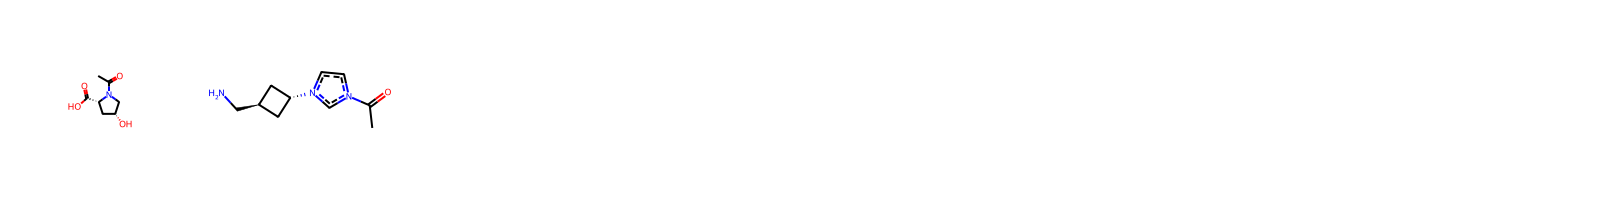

0.20946839151103766		1


(0.2668616771697998, -0.9473)

(-1.7450755834579468, 1.1405999999999998)

In [917]:
from rdkit.Chem import Draw

index = int(utility.argsort()[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    scorer.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))

<Axes: xlabel='round', ylabel='utility'>

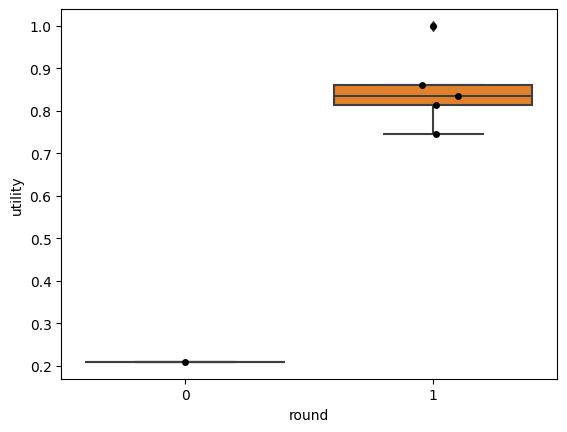

In [918]:
import pandas as pd
import seaborn as sns

sns.boxplot(
    pd.DataFrame(results_over_time),
    x='round',
    y='utility'
)

sns.stripplot(
    pd.DataFrame(results_over_time),
    x='round',
    y='utility',
    color='#000'
)

In [32]:
from dgym.agents import DrugAgent

In [33]:
drug_agent = DrugAgent(drug_env.action_space)